In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.plot
from rasterio.mask import mask
import xarray as xr
import dask

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = './data/'
raw = 'raw'
processed = 'processed'
type_of_data = 'climate'

kenya_name = 'kenya'
rwanda_name = 'rwanda'
tanzania_name = 'tanzania'
uganda_name = 'uganda'

#precipitation (mm)
precip_folder = '/wc2.1_2.5m_prec_2000-2018/'

#min temp (C)
mintemp_folder = '/wc2.1_2.5m_tmin_2000-2018/'

#max temp (C)
maxtemp_folder = '/wc2.1_2.5m_tmax_2000-2018/'

load = os.path.join(data_path, raw, type_of_data)
append_out = '_'+type_of_data+'_'+processed+'.csv'

#where to save to
kenya_save = os.path.join(data_path, processed, type_of_data, kenya_name+append_out)
rwanda_save = os.path.join(data_path, processed, type_of_data, rwanda_name+append_out)
tanzania_save = os.path.join(data_path, processed, type_of_data, tanzania_name+append_out)
uganda_save = os.path.join(data_path, processed, type_of_data, uganda_name+append_out)

In [3]:
print(load)
print(kenya_save)

./data/raw/climate
./data/processed/climate/kenya_climate_processed.csv


In [4]:
def load_geotiff(path):
    ds = rasterio.open(path)
    return ds

A note on the above processing method: This returns a `rasterio.io.DatasetReader` object for each path that is fed into the method. So if you wanted a NumPy array, you would need to call `ds.read()` in `load_geotiff()`. However, I am not doing that for two reasons:
1. It is much faster processing the 750+ global rasters if we store each one in as a `DatasetReader` object.
2. `rasterio` has many built in functions for plotting and doing calculations on them that we would lose if they were stored as arrays (especially for keeping geolocation data intact.

In [5]:
#maybe try to use dask data chunking here
def load_dataset(folder):
    print('Processing files in {}...'.format(folder))
    
    dataset_list = []
    
    for file in sorted(os.listdir(folder)):
        path = os.path.join(folder, file)
        ds = load_geotiff(path)
        dataset_list.append(ds)

    dataset = np.asarray(dataset_list)
    
    print('Done!\n')
    return dataset

In [6]:
precip = load_dataset(load+precip_folder)
mintemp = load_dataset(load+mintemp_folder)
maxtemp = load_dataset(load+maxtemp_folder)

Processing files in ./data/raw/climate/wc2.1_2.5m_prec_2000-2018/...
Done!

Processing files in ./data/raw/climate/wc2.1_2.5m_tmin_2000-2018/...
Done!

Processing files in ./data/raw/climate/wc2.1_2.5m_tmax_2000-2018/...
Done!



In [7]:
print(precip.shape)
print(mintemp.shape)
print(maxtemp.shape)

(228,)
(228,)
(228,)


Each dataset has 228 rasters in it, which is 12 months x 19 years in our analysis. Let's check out some of the properties in our precip dataset.

In [8]:
p = precip[0]
p.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 8640,
 'height': 4320,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.041666666666666664, 0.0, -180.0,
        0.0, -0.041666666666666664, 90.0)}

In [9]:
print(np.min(p.read()))
print(np.max(p.read()))

nan
nan


So there are some missing values from the data. We can take care of those later.

### Get continent and country boundaries from Natural Earth

Below, we are going to get country and continent borders from Natural Earth, as well as download cities that we are interested in looking at.

In [10]:
gpd.datasets.available

['naturalearth_cities', 'naturalearth_lowres', 'nybb']

In [11]:
countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
print("Geometry Column Name : ", countries.geometry.name)
print("Dataset Size : ", countries.shape)
countries.head()

Geometry Column Name :  geometry
Dataset Size :  (177, 6)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [12]:
cities = gpd.read_file(gpd.datasets.get_path("naturalearth_cities"))
print("Geometry Column Name : ", cities.geometry.name)
print("Dataset Size : ", cities.shape)
cities.head()

Geometry Column Name :  geometry
Dataset Size :  (202, 2)


,name,geometry
0,Vatican City,POINT (12.45339 41.90328)
1,San Marino,POINT (12.44177 43.93610)
2,Vaduz,POINT (9.51667 47.13372)
3,Luxembourg,POINT (6.13000 49.61166)
4,Palikir,POINT (158.14997 6.91664)


In [13]:
#list of cities we have
cities_list = ['Mombasa', 'Kigali', 'Dar es Salaam', 'Lira']
print(len(cities_list))

cities_subset = cities[cities.name.isin(cities_list)]
print(cities_subset.shape)

4
(2, 2)


In [14]:
#look at getting x,y coordinates for all cities above
print(cities_subset)

              name                   geometry
13          Kigali  POINT (30.05859 -1.95164)
144  Dar es Salaam  POINT (39.26640 -6.79807)


So we are missing the cities for Mombasa and Lira and will need to add them below. I used the points that I got from [epsg.io](https://epsg.io/), using the WGS 84 EPSG:4326 projection which matches that used all [Natural Earth](https://www.naturalearthdata.com/features/) data.

In [15]:
df = pd.DataFrame(
    {'name': ['Mombasa', 'Lira'],
     'latitude': [-4.037011, 2.263401],
     'longitude': [39.664359, 32.851754]})

In [16]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

gdf.drop(['latitude', 'longitude'], axis=1, inplace=True)

In [17]:
gdf.head()

,name,geometry
0,Mombasa,POINT (39.66436 -4.03701)
1,Lira,POINT (32.85175 2.26340)


In [18]:
cities = cities_subset.append(gdf).reset_index(drop=True)
cities.head()

,name,geometry
0,Kigali,POINT (30.05859 -1.95164)
1,Dar es Salaam,POINT (39.26640 -6.79807)
2,Mombasa,POINT (39.66436 -4.03701)
3,Lira,POINT (32.85175 2.26340)


In [19]:
africa = countries[countries.continent=='Africa']
print("Geometry Column Name : ", africa.geometry.name)
print("Dataset Size : ", africa.shape)
africa.head()

Geometry Column Name :  geometry
Dataset Size :  (51, 6)


,pop_est,continent,name,iso_a3,gdp_md_est,geometry
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
11,83301151,Africa,Dem. Rep. Congo,COD,66010.0,"POLYGON ((29.34000 -4.49998, 29.51999 -5.41998..."
12,7531386,Africa,Somalia,SOM,4719.0,"POLYGON ((41.58513 -1.68325, 40.99300 -0.85829..."
13,47615739,Africa,Kenya,KEN,152700.0,"POLYGON ((39.20222 -4.67677, 37.76690 -3.67712..."


In [20]:
have_data_list = ['Kenya', 'Rwanda', 'Tanzania', 'Uganda']
have_data = africa[africa.name.isin(have_data_list)]

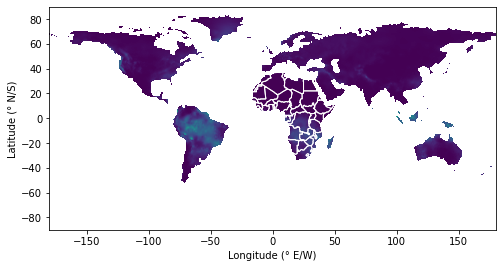

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

rasterio.plot.show(p, ax=ax)
africa.plot(facecolor='None', edgecolor='white', ax=ax, label='Not Analyzing')

ax.set_xlabel('Longitude (° E/W)')
ax.set_ylabel('Latitude (° N/S)')

plt.show()

So this is looking good, but we will want to zoom in on Africa, and then our four countries of interest, for plotting. Then we can save these clipped rasters to save room when we save the fully processed time series we are trying to extract.

In [22]:
p.read().shape

(1, 4320, 8640)

In [23]:
out_image, out_transform = mask(dataset=p, shapes=africa.geometry, crop=True)

out_meta = p.meta.copy()
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 8640,
 'height': 4320,
 'count': 1,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(0.041666666666666664, 0.0, -180.0,
        0.0, -0.041666666666666664, 90.0)}

In [24]:
out_meta.update({"driver": "GTiff",
                 #fill missing data
                 "nodata": 0,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("./data/raw/climate/wc2.1_2.5m_prec_2000-2018/wc2.1_2.5m_prec_2000-01_clipped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 1652, 'height': 1733, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.041666666666666664, 0.0, -17.666666666666686,
       0.0, -0.041666666666666664, 37.375), 'tiled': False, 'interleave': 'band'}


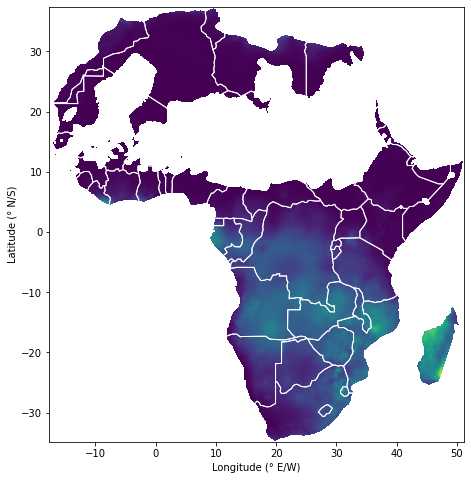

In [25]:
with rasterio.open('./data/raw/climate/wc2.1_2.5m_prec_2000-2018/wc2.1_2.5m_prec_2000-01_clipped.tif', 'r') as data3:
    print(data3.profile)
    fig, ax = plt.subplots(figsize=(8, 8))
    africa.plot(facecolor='None', edgecolor='white', ax=ax, label='Not Analyzing')
    rasterio.plot.show(data3, ax=ax)
    ax.set_xlabel('Longitude (° E/W)')
    ax.set_ylabel('Latitude (° N/S)')
    plt.show()

So the missing precipitation data is in the Saharan Desert, where there might not be precipitation readings. But luckily, all the countries that we care about for this analysis look like they have full data. I filled in the missing data values with 0 to prevent a background of NaNs from obscuring the view of our data.

### Try the same thing with countries

In [26]:
out_image, out_transform = mask(dataset=p, shapes=have_data.geometry, crop=True)

In [27]:
out_transform

Affine(0.041666666666666664, 0.0, 29.0,
       0.0, -0.041666666666666664, 5.541666666666671)

In [28]:
out_meta = p.meta.copy()

out_meta.update({"driver": "GTiff",
                 "nodata": None,
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(load+precip_folder+'/wc2.1_2.5m_prec_2000-01_clipped_coi.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

Below we can see the masks we created for Kenya, Rwanda, Tanzania, and Uganda.

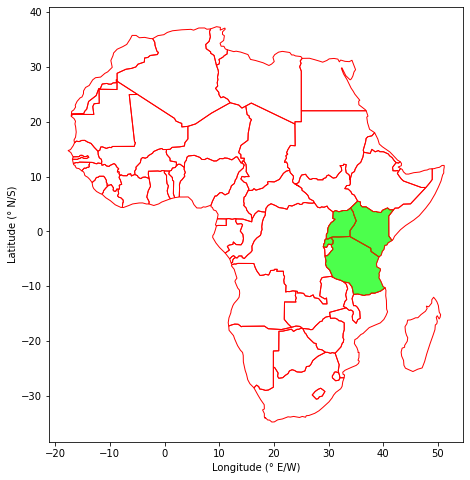

In [29]:
with rasterio.open(load+precip_folder+'/wc2.1_2.5m_prec_2000-01_clipped_coi.tif', 'r') as countries:
    fig, ax = plt.subplots(figsize=(8, 8))
    africa.plot(facecolor='None', edgecolor='red', ax=ax, label='Not Analyzing')
    have_data.plot(color='lime', edgecolor='r', alpha=0.7, ax=ax, label='Have Data')
    ax.set_xlabel('Longitude (° E/W)')
    ax.set_ylabel('Latitude (° N/S)')
    plt.show()

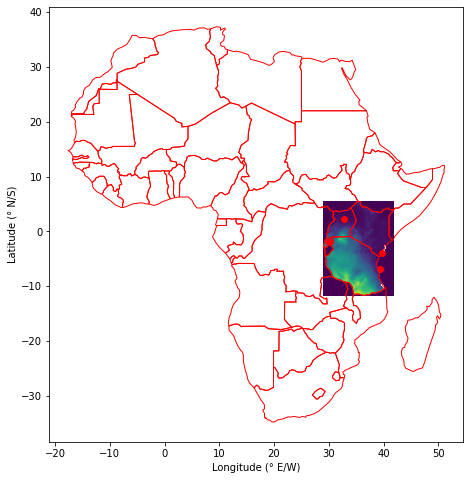

In [30]:
with rasterio.open(load+precip_folder+'/wc2.1_2.5m_prec_2000-01_clipped_coi.tif', 'r') as countries:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    africa.plot(facecolor='None', edgecolor='red', ax=ax, label='Not Analyzing')
    img = rasterio.plot.show(countries, ax=ax)
    cities.plot(color='r', ax=ax)
    
    ax.set_xlabel('Longitude (° E/W)')
    ax.set_ylabel('Latitude (° N/S)')
    plt.show()

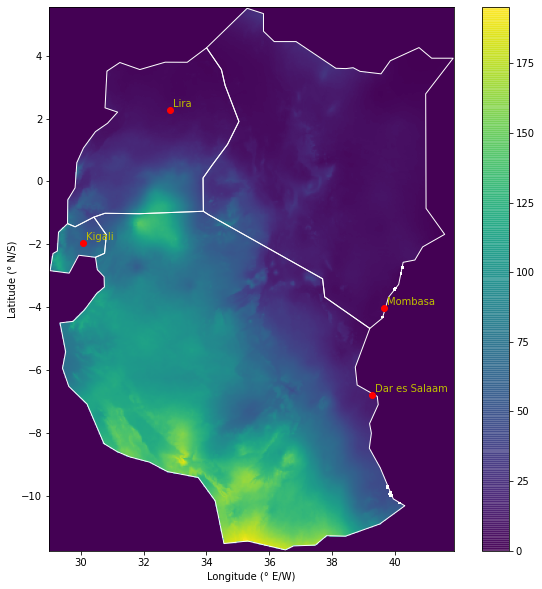

In [32]:
with rasterio.open(load+precip_folder+'/wc2.1_2.5m_prec_2000-01_clipped_coi.tif', 'r') as countries:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    have_data.plot(facecolor='none', edgecolor='white', ax=ax, label='Countries of interest')
    #img = ax.imshow(countries.read()[0], alpha=0.8)
    rasterio.plot.show(countries, with_bounds=True, ax=ax)
    
    #plot cities as points with annotations
    cities.plot(color='r', ax=ax)
    for x, y, label in zip(cities.geometry.x, cities.geometry.y, cities.name):
        ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", color='y')
        
    ax.set_xlabel('Longitude (° E/W)')
    ax.set_ylabel('Latitude (° N/S)')
    
    fig.colorbar(img, ax=ax)
    
    plt.show()

A weird processing note: I have not been able to add a colorbar to a `rasterio.plot.show()` plot. My (terrible) workaround is to plot the data as an array in Matplotlib with `imshow()`, and then run the method again with that line of code commented out. This works because data persists between Jupyter Notebook sessions.

Above I added the NaNs back into the raster so that I could do statistics at the country and city level.

Next, we need to be able to extract time series data for precipitation and temperature data for each city in our analysis. Below, we can use the `.sample()` method from `rasterio` to extract a value from a raster given a set of coordinates. We can do this at every time step to get a time series.

However, we saved a couple of files when we were testing methods, so let's remove those first.

In [33]:
!rm ./data/raw/climate/wc2.1_2.5m_prec_2000-2018/wc2.1_2.5m_prec_2000-01_clipped.tif
!rm ./data/raw/climate/wc2.1_2.5m_prec_2000-2018/wc2.1_2.5m_prec_2000-01_clipped_coi.tif

In [34]:
def extract_time_series(dataset, cities):
    d, k, l, m = [], [], [], []
    
    #extract coordinates for each city
    coords = [(point.x, point.y) for point in cities.geometry]
    kcoords, dcoords, mcoords, lcoords = coords
    
    #get value from raster for each coordinate at each time step
    for i, raster in enumerate(dataset):
        dvalue = [sample[0] for sample in raster.sample([dcoords])]
        kvalue = [sample[0] for sample in raster.sample([kcoords])]
        lvalue = [sample[0] for sample in raster.sample([lcoords])]
        mvalue = [sample[0] for sample in raster.sample([mcoords])]
        
        d.append(dvalue[0])
        k.append(kvalue[0])
        l.append(lvalue[0])
        m.append(mvalue[0])
        
    return np.asarray(d), np.asarray(k), np.asarray(l), np.asarray(m)

In [35]:
dprecip, kprecip, lprecip, mprecip = extract_time_series(precip, cities)
dtmin, ktmin, ltmin, mtmin = extract_time_series(mintemp, cities)
dtmax, ktmax, ltmax, mtmax = extract_time_series(maxtemp, cities)

In [36]:
#now make these separate datasets their own pandas dataframe by city
dclim = pd.DataFrame({'precip':dprecip, 'mintemp':dtmin, 'maxtemp':dtmax})
kclim = pd.DataFrame({'precip':kprecip, 'mintemp':ktmin, 'maxtemp':ktmax})
lclim = pd.DataFrame({'precip':lprecip, 'mintemp':ltmin, 'maxtemp':ltmax})
mclim = pd.DataFrame({'precip':mprecip, 'mintemp':mtmin, 'maxtemp':mtmax})

In [37]:
dclim.head()

,precip,mintemp,maxtemp
0,15.240020,23.680468,32.563854
1,18.204571,23.262829,33.403561
2,183.889740,24.018576,32.086720
3,194.702179,23.167221,31.602726
4,73.655739,22.194983,31.042360


Here is what one of those time series would look like for the city Dar es Salaam.

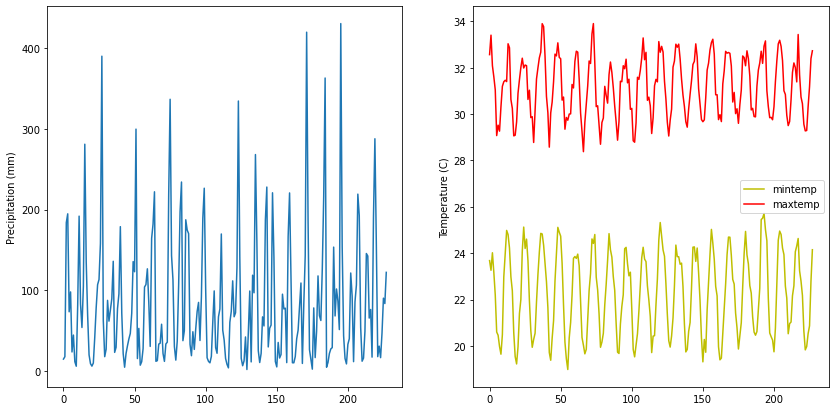

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

dclim.precip.plot(ax=ax[0])
dclim.mintemp.plot(color='y', ax=ax[1])
dclim.maxtemp.plot(color='r', ax=ax[1])

ax[0].set_ylabel('Precipitation (mm)')
ax[1].set_ylabel('Temperature (C)')

ax[1].legend()
plt.show()

Below, you will see another example from Kigali. One reason we are interested in doing this analysis is seeing how different factors affect bean prices for different cities. So for example, Kigali's precipitation pattern seems much more centered around a mean value, while there are more extremes for Dar es Salaam. Also, the difference between maximum and minimum temperatures is higher for Kigali and there seems to be less variation in the individual (max, min) temperature ranges.

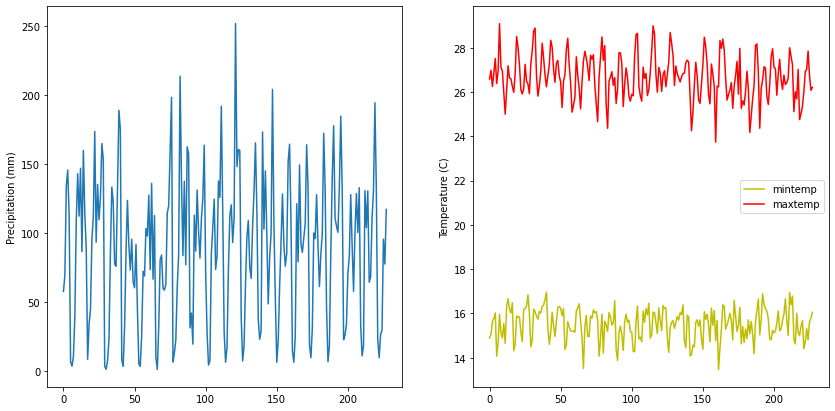

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))

kclim.precip.plot(ax=ax[0])
kclim.mintemp.plot(color='y', ax=ax[1])
kclim.maxtemp.plot(color='r', ax=ax[1])

ax[0].set_ylabel('Precipitation (mm)')
ax[1].set_ylabel('Temperature (C)')

ax[1].legend()
plt.show()

I am going to save the data by country even though we only have city-level information for now. It will be easy to join all of our disparate datasets if we can search for them by country tag.

In [44]:
#now save the data
#dclim.to_csv(tanzania_save)
#kclim.to_csv(rwanda_save)
#lclim.to_csv(uganda_save)
#mclim.to_csv(kenya_save)

## Where to go from here

- Try to take averages at the country level, plot time series
- interactive Bokeh plots? https://automating-gis-processes.github.io/CSC/lessons/L6/interactive-map-bokeh.html. This could be cool for seeing how precip changes monthly for our COI, for example
- maybe download more data from WorldClim: https://www.worldclim.org/data/worldclim21.html
- need to download more data from Modis (TIF) or TerraClimate (.nc)